Populating the interactive namespace from numpy and matplotlib
f_dig_lp:  0.0076


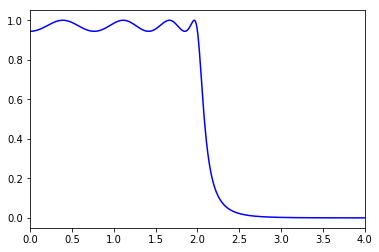

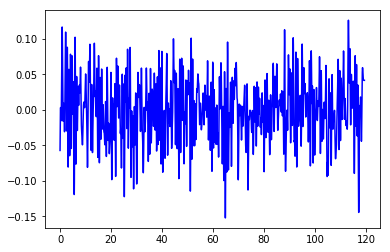

[ 1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.
  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.
  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.
  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.
  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.
  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.]
[ 1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.
 -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.
  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.]


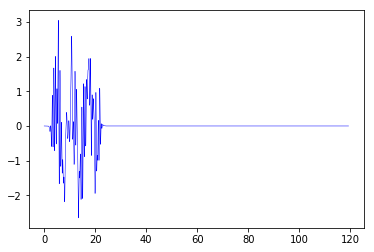

r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 0.7875 omega_m: 2.0 k_m: 0.0
simulation time: 0:19


In [1]:
%pylab inline

from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'spacetime-noise')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)


n_dim = 1
r0, r1, dr = [None]*3
S = 0.95
n_t = None
save_every = 20
source_at_right = False

r_c = None
r0_eps, r1_eps = None, None
r0_deps, r1_deps = None, None
a_eps, b_eps = None, None
omega = 1.0 #2.0*np.pi
s_pml = None
d_pml = None
set_pml = True
is_t_var = True

n = 1.5
L_0 = 2.0*np.pi/(omega)
L_n = 2.0*np.pi/(omega*n)

del_eps = 0.35*n**2
omega_m = 2*omega
k_m = 0.0
t_deps_off = np.inf

if n_dim==1:
    W_slab = np.array([5.0*L_0])
    d_pml = np.array([1.5*L_0])

    r0 = np.array([0.0])
    r1 = W_slab + 2.0*d_pml + np.array([4.0*L_0])
    dr = np.array([L_0/500])
    S /= np.sqrt(1)
    n_t = 10000#2**18

    r_c = (r0+r1)/2.0
    a_eps, b_eps = n**2, 1.0
        
    r0_eps = r0 + d_pml + L_0
    r1_eps = r0_eps + W_slab
    
    r0_deps = r0_eps
    r1_deps = r1_eps

    s_pml = np.array([1.0+5.0j/L_0])

    assert np.all(W_slab<(r1-r0)-2*d_pml)
    
dt = S*dr[0]*np.sqrt(min(a_eps-del_eps, b_eps))
d_v = np.prod(dr)


fdtd = FDTDSimulator()

fdtd.SetSimulationBox(r0, r1, dr, dt)
fdtd.save_every = save_every 

d_x_ = np.zeros(n_dim)
d_x_[0] = (r1[0]-r0[0])
d_x_pml = np.zeros(n_dim)
d_x_pml[0] = d_pml[0]


##----- filtered noise

from scipy import signal

def setLPNoiseSamples(f_anal_lp=2.0):
    t_samples = np.linspace(0.0, n_t*dt, n_t)
    f_noise = 0.2*np.random.normal(0.0, 1.0, size=n_t)
    
    f_dig_lp = f_anal_lp*dt/np.pi 
    print('f_dig_lp: ', f_dig_lp)
    b, a = signal.cheby1(8, rp=0.5, Wn=f_dig_lp*2.0*np.pi, btype='low', analog=False, output='ba')
    w, h = signal.freqz(b, a, worN=n_t)

    plt.figure()
    plt.plot(w/(2*np.pi)/dt, np.abs(h), 'b')
    xlim(0, 2.0*f_anal_lp)
    plt.show()

    noise_LP = signal.filtfilt(b, a, f_noise, padlen=0)
    plt.figure()
    plt.plot(t_samples, noise_LP, 'b')
    plt.show()
    return noise_LP

noise_LP = None
read_saved_noise = False

if not read_saved_noise:
    noise_LP = setLPNoiseSamples()
    np.savez(os.path.join(dir_name, 'noise_LP'), noise_LP=noise_LP)
else:
    data_noise_LP = np.load(os.path.join(dir_name, 'noise_LP.npz'))
    noise_LP = data_noise_LP['noise_LP']

def f_noise_LP(t):
    i_t = int(t//dt)
    if i_t<n_t-1:
        alpha = (t-i_t*dt)/dt
        return (1-alpha)*noise_LP[i_t] + alpha*noise_LP[i_t+1]
    else:
        return 0.0
    
def f_pulse_am(t, a_0, w_0, T_pulse, t_rise):
    f_t = 0.5*a_0*np.sin(w_0*t)*(np.tanh(t/t_rise) - np.tanh((t-T_pulse)/t_rise))
    return f_t

def f_ook(t, seq, a_0, w_0, T_pulse, t_rise):
    ind = int(t/T_pulse)
    A_0 = a_0*seq[ind]
    t_start = ind*T_pulse
    f_t = f_pulse_am(t-t_start, A_0, w_0, T_pulse, t_rise)
    return f_t
    
    
#seq = np.floor(2.0*np.random.rand(100))
#print(seq)
seq = np.array([1.0, 0, 1.0, 0, 1, 0, 1, 0] + np.floor(2.0*np.random.rand(100)).tolist())
print(seq)

seq = seq-(seq==0.0)
print(seq)

##------

smooth_rect = lambda t, t0, t1, T_rise: 0.5*(np.tanh((t - t1)/T_rise) - np.tanh((t - t0)/T_rise))


T_per = 2.0*np.pi/omega
T0_sig = 3.0*T_per

t0 = T0_sig*2
noise = lambda t: 2.0*f_noise_LP(t)*np.exp(-(t-t0)**2/(t0/4)**2)*(t<=t0) + 2.0*f_noise_LP(t)*(t>t0)
phi = 0.0/180.0*np.pi
#f_t = lambda t: 1.0*np.cos(omega*(t-t0)+phi)*np.exp(-(t-t0)**2/T0_sig**2)# + 10.0*noise(t)

T_sig_del = 0.5*T_per
T_sig_rise = 0.1*T_per
f_t = lambda t: 1.0*np.sin(omega*t+phi)*smooth_rect(t, T_sig_del, T0_sig+T_sig_del, T_sig_rise) + 20.0*f_noise_LP(t)*smooth_rect(t, 0.5*T_per, T0_sig+0.5*T_per, 0.1*T_per)

#f_t = lambda t: f_ook(t, seq, 0.1, omega, 10.0*T_per, T_per/2) + 0.5*noise(t)
#f_t = lambda t: 0.5*noise(t)
f_t_dt = lambda t: f_t(t-dt/2)

plt.figure()
t_samples = np.linspace(0.0, n_t*dt, n_t)
signal = np.array([f_t(t_samples[i]) for i in range(n_t)])
plt.plot(t_samples, signal, 'b', lw=0.5)
plt.savefig(os.path.join(dir_name, 'sig-0' + file_ext), bbox_inches='tight', pad_inches=0.2)
plt.show()

## J
r_j = r0_eps - (r0_eps-d_pml)/2
r_j -= r_j - int(r_j/dr[0])*dr[0]
je_mag = 1.0/dr[0]
src_dir = 'z'
je_type = FVTypes.JePoint
je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}
fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

## M
r_m = r_j - dr[0]/2      
jm_mag = -1.0/dr[0]/np.sqrt(b_eps)
src_dir = 'y'
jm_type = FVTypes.JmPoint
jm_args = {'r0':r_m, 'mag':jm_mag, 'f_t':f_t_dt, 'src_dir':src_dir}
fdtd.AddSources({'type':jm_type, 'name':'Jm', 'args':jm_args})


eps_args = {'r0':r0_eps, 'r1':r1_eps, 'mag_in':a_eps, 'mag_out':b_eps}
fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})

deps = None
f_deps = None
deps_out = []

r_R_1d = r_j - (r_j-d_pml)/2.0
r_T_1d = r1_eps + (r1-d_pml-r1_eps)/10
print('r0:', r0, 'r1:', r1)
print('r_T_1d:', r_T_1d, 'r_R_1d:', r_R_1d)

t_deps_off = (W_slab*n + r0_eps-r_j + (r_T_1d - r1_eps) + T_sig_del + T0_sig)[0]

if is_t_var:
    print('del_eps:', del_eps, 'omega_m:', omega_m, 'k_m:', k_m)
    a_deps = lambda r, t: del_eps*np.cos(omega_m*t - k_m*r[0])*(t<t_deps_off)
    if n_dim==1:
        a_deps = lambda r, t: del_eps*np.cos(omega_m*t - k_m*r)*(t<t_deps_off)
    deps_args = {'r0':r0_deps, 'r1':r1_deps, 'mag_in':a_deps, 'mag_out':0.0}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoSTvarBox, 'name':'deps', 'args':deps_args})
    
if set_pml:
    pml_args = {'d_pml':d_pml, 's_pml':s_pml}
    fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

set_Efields_entire_out = True
set_eps_out = False
set_j_out = False
set_T_1d = True
set_R_1d = True


if set_Efields_entire_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})
if set_j_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'Je', 'A_dir':'z', 'O_dir':None, 'name':'J'}})
if n_dim==1 and set_T_1d:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_T_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'T'}})
if n_dim==1 and set_R_1d:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_R_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'R'}})
        
if is_t_var and set_eps_out:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'deps', 'A_dir':'x', 'O_dir':None, 'name':'Eps'}})


fdtd.StepFields(n_t)
n_saved = fdtd.n_saved
    


In [2]:
import matplotlib.pyplot as plt

r_E, E_out_list = None, None
x_E, y_E, z_E = [None]*3
if set_Efields_entire_out:
    r_E, E_out_list = fdtd.GetOutputs('E')
    if n_dim==3:
        x_E, y_E, z_E = r_E
    elif n_dim==2:
        x_E, y_E = r_E
    elif n_dim==1:
        x_E = r_E[0]
    e_max = [np.max(np.abs(e)) for e in E_out_list]
    print('max(e_max):', max(e_max))
    e_max = max(e_max)
    
x_J, y_J, z_J = [None]*3
j_max = None
J_out_list = None
if set_j_out:
    r_J, J_out_list = fdtd.GetOutputs('J')
    if n_dim==3:
        x_J, y_J, z_J = r_J
    elif n_dim==2:
        x_J, y_J = r_J
    elif n_dim==1:
        x_J = r_J[0]
    j_max = [np.max(np.abs(j)) for j in J_out_list]
    print('max(j_max):', max(j_max))
    j_max = max(j_max)



x_deps, y_deps, z_deps = [None]*3
deps_out_list = None
deps_max = None
if is_t_var and set_eps_out:
    r_deps, deps_out_list = fdtd.GetOutputs('Eps')
    if n_dim==3:
        x_deps, y_deps, z_deps = r_deps
    elif n_dim==2:
        x_deps, y_deps = r_deps
    elif n_dim==1:
        x_deps = r_deps[0]
    deps_max = [np.max(np.abs(de)) for de in deps_out_list]
    print('max(deps_max):', max(deps_max))
    deps_max = max(deps_max)


x_T = None
T_arr = None
if n_dim==1 and set_T_1d:
    r_T, T_out_list = fdtd.GetOutputs('T')
    x_T = r_T[0]
    T_arr = np.array([t[0] for t in T_out_list])
    T_max = np.max(np.abs(T_arr))
    print('max(T):', T_max)
    
x_R = None
R_arr = None
if n_dim==1 and set_R_1d:
    r_R, R_out_list = fdtd.GetOutputs('R')
    x_R = r_R[0]
    R_arr = np.array([t[0] for t in R_out_list])
    R_max = np.max(np.abs(R_arr))
    print('max(R):', R_max)
    
    
#print(x_E.shape, E_out_list[0].shape)
n_run = 0

max(e_max): 31.9072206672
max(T): 18.6127701143
max(R): 18.1997819636


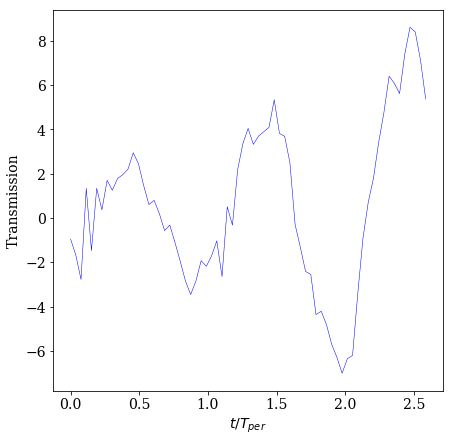

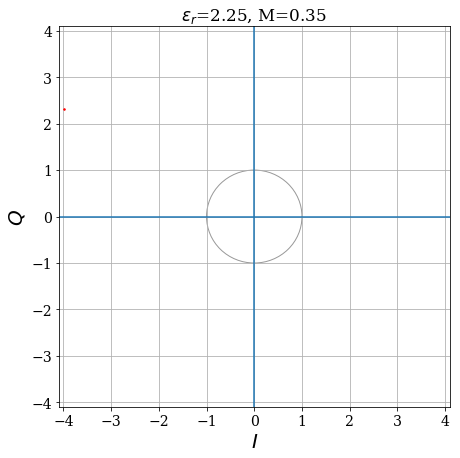

In [3]:
## get the quadratures
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle

plt.rcParams["figure.figsize"] = (7, 7)
font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
matplotlib.rc('font', **font)

np.savez(os.path.join(dir_name, 'T_arr-eps={0:.2f}-M={1:.2f}'.format(n**2, del_eps/n**2)), T_arr=T_arr)

if set_T_1d:
    #ind_st = int((r1_eps[0] - r0_eps[0])/dt*a_eps + (8*L_0_air + t0)/dt)
    
    del_n = np.sqrt(n**2+del_eps) - n
    n_avg = n
    ind_st = int((W_slab*n_avg + r0_eps-r_j + (r_T_1d - r1_eps) + T_sig_del + 2*T_sig_rise)//(dt*save_every))
    ind_end = int((W_slab*n_avg + r0_eps-r_j + (r_T_1d - r1_eps) + T_sig_del + T0_sig - 2*T_sig_rise)//(dt*save_every))
    T_arr_trimmed = T_arr[ind_st:ind_end]
    
    plt.figure(1)
    plt.plot(np.arange(len(T_arr_trimmed))*dt*save_every/(2.0*np.pi/omega), T_arr_trimmed, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Transmission')
    plt.savefig(os.path.join(dir_name, 'T-eps={0:.2f}-M={1:.2f}'.format(n**2, del_eps/n**2) + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    omega_numerical = omega
    
    Q_sin = []
    Q_cos = []

    t_samples_T = np.linspace(ind_st*dt*save_every, ind_end*dt*save_every, len(T_arr_trimmed))
    q_cos = np.sum(T_arr_trimmed*np.cos(omega_numerical*t_samples_T))/(ind_end-ind_st)*2
    q_sin = np.sum(T_arr_trimmed*np.sin(omega_numerical*t_samples_T))/(ind_end-ind_st)*2
    #print(T_arr_trimmed[i*num_per*nt_per + i], end=' ')

    Q_cos.append(q_cos)
    Q_sin.append(q_sin)
    
    Q_cos = np.array(Q_cos)
    Q_sin = np.array(Q_sin)
    Q_mag = Q_cos**2 + Q_sin**2
    Q_angle = np.arccos(Q_cos/Q_mag)
        
    plt.figure(2)
    plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
    #plt.polar(Q_angle, Q_mag)
    IQ_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin))) + 0.1
    plt.xlim(-IQ_max, IQ_max)
    plt.ylim(-IQ_max, IQ_max)
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.xlabel(r'$I$', fontsize=20)
    plt.ylabel(r'$Q$', fontsize=20)
    plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}'.format(n**2, del_eps/n**2))
    plt.grid()
    
    circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
    plt.gca().add_artist(circle)
    
    plt.savefig(os.path.join(dir_name, 'IQ-eps={0:.2f}-M={1:.2f}'.format(n**2, del_eps/n**2) + file_ext), bbox_inches='tight', pad_inches=0.5)
    plt.show()
    
n_run = 0

set_T_1d: True


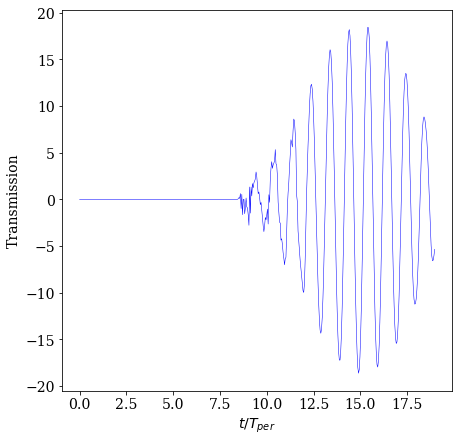

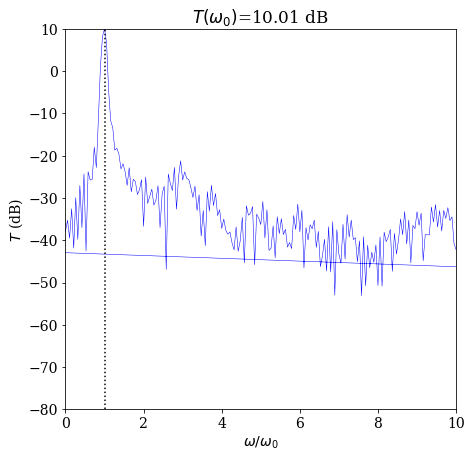

set_R_1d: True


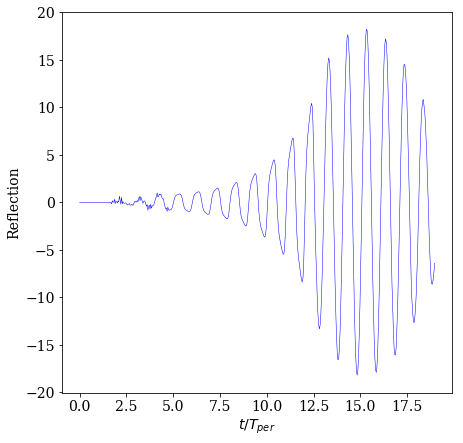

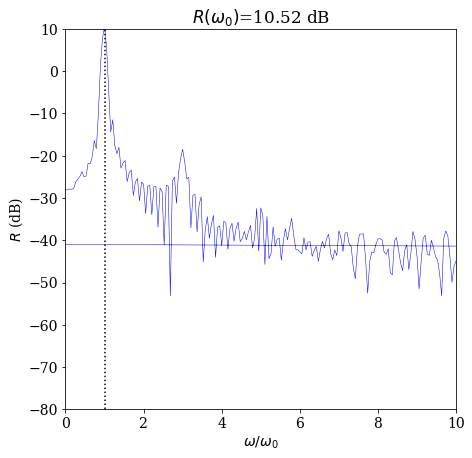

In [4]:

if set_T_1d:
    print('set_T_1d:', set_T_1d)
    f__0 = omega/(2.0*np.pi)
    d__f = omega_m/((2.0*np.pi))
    #T_arr = T_arr[int(len(T_arr)/2):]
    #T_arr = T_arr - np.load(os.path.join(dir_name, 'T-s.npz'))['T_arr']
    plt.figure()
    plt.plot(np.arange(len(T_arr))*dt*save_every/(2.0*np.pi/omega), T_arr, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Transmission')
    plt.savefig(os.path.join(dir_name, 'T' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    np.savez(os.path.join(dir_name, 'T'), T_arr=T_arr)

    T_fft = np.fft.fft(T_arr)
    T_fft = np.abs(T_fft)/len(T_fft)
    freq = np.fft.fftfreq(T_fft.shape[-1], dt*save_every)
    """
    plt.figure()
    plt.plot(freq, T_fft)
    plt.gca().set_xlim([f__0-10.0*d__f, f__0+10.0*d__f])
    plt.gca().set_ylim([0, T_max])
    plt.xlabel(r'$f$')
    plt.ylabel(r'$\log(T)$')
    plt.show()
    """
    ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
    plt.figure()
    plt.plot(2.0*np.pi*freq/omega, 20*np.log10(T_fft), 'b', lw=0.5)
    #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
    plt.xlabel(r'$\omega/\omega_0$')
    plt.ylabel(r'$T$ (dB)')
    plt.title('$T(\omega_0)$={0:.2f} dB'.format(20*np.log10(T_fft[ind])))
    plt.xlim(0.0, 10)
    plt.ylim([-80.0, 10.0])
    plt.axvline(x=1, color='k', linestyle=':')
    plt.savefig(os.path.join(dir_name, 'T-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

if set_R_1d:
    print('set_R_1d:', set_R_1d)
    f__0 = omega/(2.0*np.pi)
    d__f = omega_m/((2.0*np.pi))
    #R_arr = R_arr[int(len(R_arr)/2):]
    #R_arr = R_arr - np.load(os.path.join(dir_name, 'R-s.npz'))['R_arr']
    plt.figure()
    plt.plot(np.arange(len(R_arr))*dt*save_every/(2.0*np.pi/omega), R_arr, 'b', lw=0.5)
    plt.xlabel(r'$t/T_{per}$')
    plt.ylabel(r'Reflection')
    plt.savefig(os.path.join(dir_name, 'R' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()

    np.savez(os.path.join(dir_name, 'R'), R_arr=R_arr)
    
    R_fft = np.fft.fft(R_arr)
    R_fft = np.abs(R_fft)/len(R_fft)
    freq = np.fft.fftfreq(R_fft.shape[-1], dt*save_every)
    #plt.figure()
    #plt.plot(freq, R_fft)
    #plt.gca().set_xlim([f__0-10.0*d__f, f__0+10.0*d__f])
    #plt.gca().set_ylim([0, R_max])
    #plt.xlabel(r'$f$')
    #plt.ylabel(r'$\log(R)$')
    #plt.show()

    ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
    plt.figure()
    plt.plot(2.0*np.pi*freq/omega, 20*np.log10(R_fft), 'b', lw=0.5)
    #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
    plt.gca().set_ylim([-80.0, 10.0])
    plt.xlabel(r'$\omega/\omega_0$')
    plt.ylabel(r'$R$ (dB)')
    plt.title('$R(\omega_0)$={0:.2f} dB'.format(20*np.log10(R_fft[ind])))
    plt.xlim(0.0, 10)
    plt.ylim([-80.0, 10.0])
    plt.axvline(x=1, color='k', linestyle=':')
    plt.savefig(os.path.join(dir_name, 'R-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
    plt.show()


In [6]:
%pylab tk

Populating the interactive namespace from numpy and matplotlib


In [7]:

## animations
assert set_Efields_entire_out

import matplotlib.animation as animation
import matplotlib

# Set up formatting for the movie files
#Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
#writer = Writer(fps=15, metadata=dict(artist='Me'))
#writer = animation.FFMpegWriter()

plt.rcParams["figure.figsize"] = (5, 2.5)

plt_field = 'E'
save_anim = False
file_format = 'mp4'   ## 'gif' / 'mp4'

logscale=False
log_0 = np.log(e_max)-10

use_subplots = False

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
matplotlib.rc('font', **font)

fig, axarr = None, None
#e_max = 0
def animate_E(i):
    global e_max
    if not is_t_var:
        plt.clf()
        fig = plt.plot(x_E, E_out_list[i])
        axes = plt.gca()
        axes.set_ylim([-e_max, e_max])
        return fig
    else:
        if not use_subplots:
            plt.clf()
            fig = None
            if plt_field=='E':
                fig = plt.plot(x_E/L_0, E_out_list[i])
                ax = plt.gca()
                #e_max = max(e_max, int(np.max(np.abs(E_out_list[i]))/5.0)*5.0 + 1.0)
                ax.set_ylim([-e_max, e_max])
                #ax.set_ylim([-2.0, 2.0])
                #ax.axes.get_xaxis().set_ticks([])
                #ax.axes.get_yaxis().set_ticks([])
            elif plt_field=='Eps':
                fig = plt.plot(x_deps, deps_out_list[i], 'r', lw=0.5)
                ax = plt.gca()
                ax.set_ylim([-deps_max, deps_max])
                ax.axes.get_xaxis().set_ticks([])
            #fig.set_tight_layout(True)
            plt.xlabel(r'$z/\lambda_0$')
            plt.ylabel(r'$E(t)$')
            ax = plt.gca()
            ax.set_adjustable('box-forced')
            #plt.gcf().subplots_adjust(left=0.2, bottom=0.3)
            
            deps_color = 'y'
            if i*save_every*dt>t_deps_off:
                deps_color = 'k'
                plt.title('*', fontsize=22)
            
            plt.axvline(x=r0_deps[0]/L_0, linewidth=2.0, linestyle='-.',color=deps_color)
            plt.axvline(x=r1_deps[0]/L_0, linewidth=2.0, linestyle='-.',color=deps_color)

            plt.axvline(x=r0_eps[0]/L_0, linewidth=1.0, linestyle='-.',color=deps_color)
            plt.axvline(x=r1_eps[0]/L_0, linewidth=1.0, linestyle='-.',color=deps_color)

            #plt.tight_layout(pad=0.0)
            
            plt.axvline(x=d_pml[0]/L_0, linewidth=0.5, linestyle=':',color='g')
            plt.axvline(x=(r1-d_pml)[0]/L_0, linewidth=0.5, linestyle=':',color='g')

            #plt.axvline(x=r_T_1d[0]/L_0, linewidth=0.5, linestyle=':',color='r')
            plt.plot(r_T_1d/L_0, [0], 'ro', markersize=5)
            #plt.plot(r_R_1d/L_0, [0], 'go', markersize=5)
            
            if i%100==0:
                print("{}/{}".format(i, n_saved), end=" ")
            
            return fig
        else:
            plt.clf()
            fig, axarr = plt.subplots(2, sharex=True)
            axarr[0].plot(x_E, E_out_list[i])
            axarr[0].set_ylim([-e_max, e_max])
            axarr[1].plot(x_deps, deps_out_list[i], 'r')
            axarr[1].set_ylim([-deps_max, deps_max])
            return fig


def animate_J(i):
    plt.clf()
    fig = plt.plot(x_J, J_out_list[i])
    axes = plt.gca()
    axes.set_ylim([-j_max, j_max])
    return fig

anim = None
if is_t_var and use_subplots:
    fig, axarr = plt.subplots(2, sharex=True)
else:
    fig = plt.figure()

if plt_field=='E' or plt_field=='Eps':
    anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1)
elif plt_field=='J':
    anim = animation.FuncAnimation(fig, animate_J, frames=n_saved, interval=1)
else:
    raise ValuError()

if save_anim:
    if file_format=='gif':
        anim.save(os.path.join(dir_name, 'E1d-anim.gif'), writer="imagemagick", fps=15, dpi=200)
    elif file_format=='mp4':
        anim.save(os.path.join(dir_name, 'E1d-anim.mp4'), writer="ffmpeg", fps=15, dpi=200)
plt.show()
    


### Run for many points

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.211425347
max(T): 357.841066883
max(R): 354.068885798
0/100 


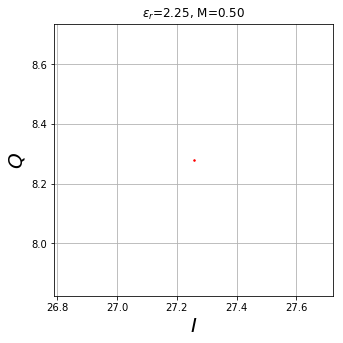

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 706.624892467
max(T): 357.547144625
max(R): 353.796267472
1/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:20
max(e_max): 706.574369829
max(T): 357.516242668
max(R): 353.762509022
2/100 


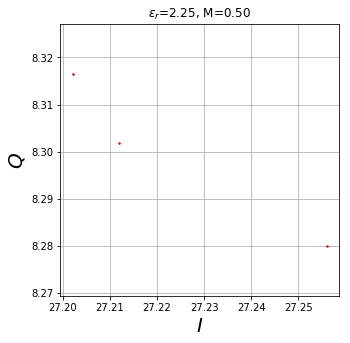

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 706.316632762
max(T): 357.388176723
max(R): 353.637382211
3/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 706.810179353
max(T): 357.637857419
max(R): 353.882735787
4/100 


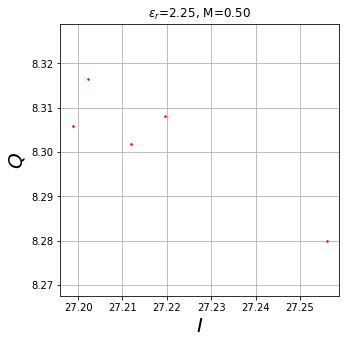

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 706.880457904
max(T): 357.677381696
max(R): 353.907169653
5/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.66288597
max(T): 358.069774933
max(R): 354.297396147
6/100 


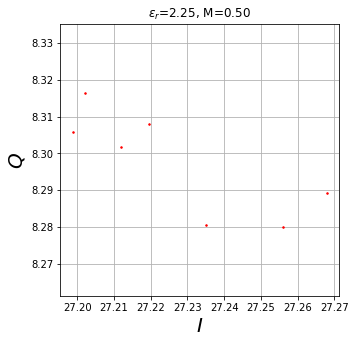

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.846101391
max(T): 358.166892005
max(R): 354.40299613
7/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.823057103
max(T): 358.152252406
max(R): 354.386798663
8/100 


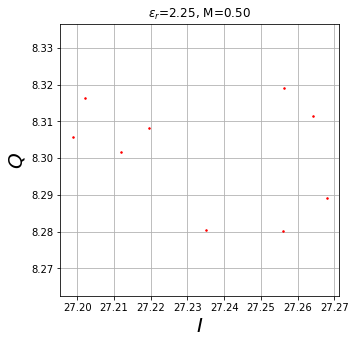

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.75064453
max(T): 358.114833853
max(R): 354.345804619
9/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:20
max(e_max): 708.559252565
max(T): 358.517397909
max(R): 354.746682472
10/100 


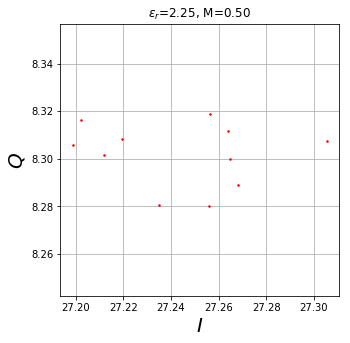

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.110998361
max(T): 357.793136363
max(R): 354.036352125
11/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 706.90149701
max(T): 357.682563735
max(R): 353.930557031
12/100 


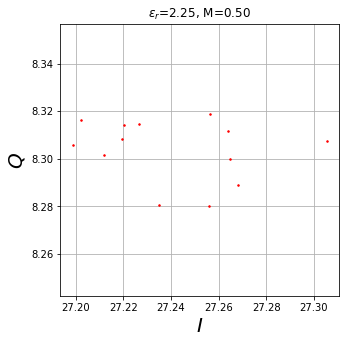

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.082161986
max(T): 357.770913349
max(R): 354.01265372
13/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 707.958531819
max(T): 358.217106898
max(R): 354.456471605
14/100 


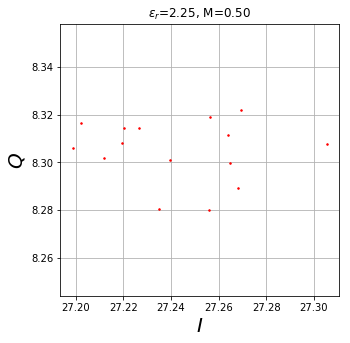

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 706.577697802
max(T): 357.521391466
max(R): 353.776341088
15/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:19
max(e_max): 708.088555663
max(T): 358.286318268
max(R): 354.52331156
16/100 


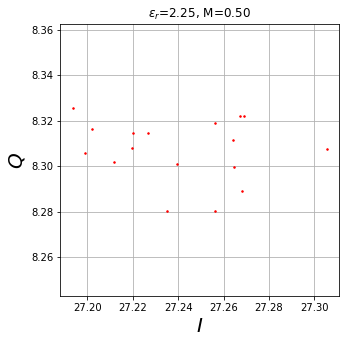

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:20
max(e_max): 708.954914768
max(T): 358.720426488
max(R): 354.94648042
17/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:20
max(e_max): 707.962664765
max(T): 358.227101863
max(R): 354.463706811
18/100 


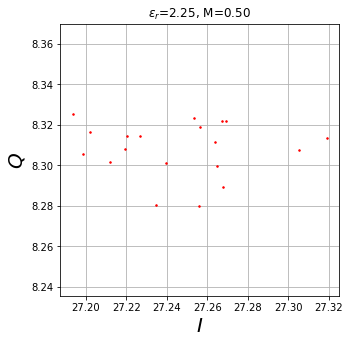

f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0
simulation time: 0:21
max(e_max): 706.977686371
max(T): 357.723032356
max(R): 353.960511042
19/100 
f_dig_lp:  0.0076
r0: [ 0.] r1: [ 75.39822369]
r_T_1d: [ 49.0088454] r_R_1d: [ 10.9892911]
del_eps: 1.125 omega_m: 2.0 k_m: 0.0


KeyboardInterrupt: 

In [5]:
%pylab tk

from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'spacetime-noise')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

figsize(3,3)
e_max = 0.0

def Run_IQ(n_refr_ind, M_eps_mod_ind, amp_noise=20.0, phi_slab_deg=0.0, phi_detect_deg=0.0, \
               save_every = 1, show_figs = False, show_animation=False):
    global e_max
    n_dim = 1
    r0, r1, dr = [None]*3
    S = 0.95
    n_t = None
    save_every = save_every
    source_at_right = False

    r_c = None
    r0_eps, r1_eps = None, None
    r0_deps, r1_deps = None, None
    a_eps, b_eps = None, None
    omega = 1.0 #2.0*np.pi
    s_pml = None
    d_pml = None
    set_pml = True
    is_t_var = True

    n = n_refr_ind
    L_0 = 2.0*np.pi/(omega)
    L_n = 2.0*np.pi/(omega*n)

    del_eps = M_eps_mod_ind*n**2
    omega_m = 2*omega
    k_m = 0.0
    t_deps_off = np.inf

    if n_dim==1:
        W_slab = np.array([5.0*L_0])
        d_pml = np.array([1.5*L_0])

        r0 = np.array([0.0])
        r1 = W_slab + 2.0*d_pml + np.array([4.0*L_0])
        dr = np.array([L_0/500])
        S /= np.sqrt(1)
        n_t = 10000#2**18

        r_c = (r0+r1)/2.0
        a_eps, b_eps = n**2, 1.0

        r0_eps = r0 + d_pml + L_0
        r1_eps = r0_eps + W_slab

        r0_deps = r0_eps
        r1_deps = r1_eps

        s_pml = np.array([1.0+5.0j/L_0])

        assert np.all(W_slab<(r1-r0)-2*d_pml)

    dt = S*dr[0]*np.sqrt(min(a_eps-del_eps, b_eps))
    d_v = np.prod(dr)


    fdtd = FDTDSimulator()

    fdtd.SetSimulationBox(r0, r1, dr, dt)
    fdtd.save_every = save_every 

    d_x_ = np.zeros(n_dim)
    d_x_[0] = (r1[0]-r0[0])
    d_x_pml = np.zeros(n_dim)
    d_x_pml[0] = d_pml[0]


    ##----- filtered noise

    from scipy import signal

    def setLPNoiseSamples(f_anal_lp=2.0):
        t_samples = np.linspace(0.0, n_t*dt, n_t)
        f_noise = 0.2*np.random.normal(0.0, 1.0, size=n_t)

        f_dig_lp = f_anal_lp*dt/np.pi 
        print('f_dig_lp: ', f_dig_lp)
        b, a = signal.cheby1(8, rp=0.5, Wn=f_dig_lp*2.0*np.pi, btype='low', analog=False, output='ba')
        w, h = signal.freqz(b, a, worN=n_t)

        if show_figs:
            plt.figure()
            plt.plot(w/(2*np.pi)/dt, np.abs(h), 'b')
            xlim(0, 2.0*f_anal_lp)
            plt.show()

        noise_LP = signal.filtfilt(b, a, f_noise, padlen=0)
        if show_figs:
            plt.figure()
            plt.plot(t_samples, noise_LP, 'b')
            plt.show()
        return noise_LP

    noise_LP = None
    read_saved_noise = False

    if not read_saved_noise:
        noise_LP = setLPNoiseSamples()
        np.savez(os.path.join(dir_name, 'noise_LP'), noise_LP=noise_LP)
    else:
        data_noise_LP = np.load(os.path.join(dir_name, 'noise_LP.npz'))
        noise_LP = data_noise_LP['noise_LP']

    def f_noise_LP(t):
        i_t = int(t//dt)
        if i_t<n_t-1:
            alpha = (t-i_t*dt)/dt
            return (1-alpha)*noise_LP[i_t] + alpha*noise_LP[i_t+1]
        else:
            return 0.0

    ##------

    smooth_rect = lambda t, t0, t1, T_rise: 0.5*(np.tanh((t - t1)/T_rise) - np.tanh((t - t0)/T_rise))


    T_per = 2.0*np.pi/omega
    T0_sig = 3.0*T_per

    t0 = T0_sig*2
    noise = lambda t: 2.0*f_noise_LP(t)*np.exp(-(t-t0)**2/(t0/4)**2)*(t<=t0) + 2.0*f_noise_LP(t)*(t>t0)
    phi_slab = phi_slab_deg/180.0*np.pi
    #f_t = lambda t: 1.0*np.cos(omega*(t-t0)+phi)*np.exp(-(t-t0)**2/T0_sig**2)# + 10.0*noise(t)

    T_sig_del = 0.5*T_per
    T_sig_rise = 0.1*T_per
    f_t = lambda t: 1.0*np.sin(omega*t+phi_slab)*smooth_rect(t, T_sig_del, T0_sig+T_sig_del, T_sig_rise) \
        + amp_noise*f_noise_LP(t)*smooth_rect(t, 0.5*T_per, T0_sig+0.5*T_per, 0.1*T_per)

    #f_t = lambda t: f_ook(t, seq, 0.1, omega, 10.0*T_per, T_per/2) + 0.5*noise(t)
    #f_t = lambda t: 0.5*noise(t)
    f_t_dt = lambda t: f_t(t-dt/2)

    if show_figs:
        plt.figure()
        t_samples = np.linspace(0.0, n_t*dt, n_t)
        signal = np.array([f_t(t_samples[i]) for i in range(n_t)])
        plt.plot(t_samples, signal, 'b', lw=0.5)
        plt.savefig(os.path.join(dir_name, 'sig-0' + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()

    ## J
    r_j = r0_eps - (r0_eps-d_pml)/2
    r_j -= r_j - int(r_j/dr[0])*dr[0]
    je_mag = 1.0/dr[0]
    src_dir = 'z'
    je_type = FVTypes.JePoint
    je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}
    fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

    ## M
    r_m = r_j - dr[0]/2      
    jm_mag = -1.0/dr[0]/np.sqrt(b_eps)
    src_dir = 'y'
    jm_type = FVTypes.JmPoint
    jm_args = {'r0':r_m, 'mag':jm_mag, 'f_t':f_t_dt, 'src_dir':src_dir}
    fdtd.AddSources({'type':jm_type, 'name':'Jm', 'args':jm_args})


    eps_args = {'r0':r0_eps, 'r1':r1_eps, 'mag_in':a_eps, 'mag_out':b_eps}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})

    deps = None
    f_deps = None
    deps_out = []

    r_R_1d = r_j - (r_j-d_pml)/2.0
    r_T_1d = r1_eps + (r1-d_pml-r1_eps)/10
    print('r0:', r0, 'r1:', r1)
    print('r_T_1d:', r_T_1d, 'r_R_1d:', r_R_1d)

    t_deps_off = (W_slab*n + r0_eps-r_j + (r_T_1d - r1_eps) + T_sig_del + T0_sig)[0]

    if is_t_var:
        print('del_eps:', del_eps, 'omega_m:', omega_m, 'k_m:', k_m)
        a_deps = lambda r, t: del_eps*np.cos(omega_m*t - k_m*r[0])*(t<t_deps_off)
        if n_dim==1:
            a_deps = lambda r, t: del_eps*np.cos(omega_m*t - k_m*r)*(t<t_deps_off)
        deps_args = {'r0':r0_deps, 'r1':r1_deps, 'mag_in':a_deps, 'mag_out':0.0}
        fdtd.AddMaterial({'type':FVTypes.EpsIsoSTvarBox, 'name':'deps', 'args':deps_args})

    if set_pml:
        pml_args = {'d_pml':d_pml, 's_pml':s_pml}
        fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

    set_Efields_entire_out = True
    set_eps_out = False
    set_j_out = False
    set_T_1d = True
    set_R_1d = True


    if set_Efields_entire_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})
    if set_j_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'Je', 'A_dir':'z', 'O_dir':None, 'name':'J'}})
    if n_dim==1 and set_T_1d:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_T_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'T'}})
    if n_dim==1 and set_R_1d:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_R_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'R'}})

    if is_t_var and set_eps_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'deps', 'A_dir':'x', 'O_dir':None, 'name':'Eps'}})


    fdtd.StepFields(n_t)
    n_saved = fdtd.n_saved


    r_E, E_out_list = None, None
    x_E, y_E, z_E = [None]*3
    if set_Efields_entire_out:
        r_E, E_out_list = fdtd.GetOutputs('E')
        if n_dim==3:
            x_E, y_E, z_E = r_E
        elif n_dim==2:
            x_E, y_E = r_E
        elif n_dim==1:
            x_E = r_E[0]
        e_max = [np.max(np.abs(e)) for e in E_out_list]
        print('max(e_max):', max(e_max))
        e_max = max(e_max)

    x_J, y_J, z_J = [None]*3
    j_max = None
    J_out_list = None
    if set_j_out:
        r_J, J_out_list = fdtd.GetOutputs('J')
        if n_dim==3:
            x_J, y_J, z_J = r_J
        elif n_dim==2:
            x_J, y_J = r_J
        elif n_dim==1:
            x_J = r_J[0]
        j_max = [np.max(np.abs(j)) for j in J_out_list]
        print('max(j_max):', max(j_max))
        j_max = max(j_max)



    x_deps, y_deps, z_deps = [None]*3
    deps_out_list = None
    deps_max = None
    if is_t_var and set_eps_out:
        r_deps, deps_out_list = fdtd.GetOutputs('Eps')
        if n_dim==3:
            x_deps, y_deps, z_deps = r_deps
        elif n_dim==2:
            x_deps, y_deps = r_deps
        elif n_dim==1:
            x_deps = r_deps[0]
        deps_max = [np.max(np.abs(de)) for de in deps_out_list]
        print('max(deps_max):', max(deps_max))
        deps_max = max(deps_max)


    x_T = None
    T_arr = None
    if n_dim==1 and set_T_1d:
        r_T, T_out_list = fdtd.GetOutputs('T')
        x_T = r_T[0]
        T_arr = np.array([t[0] for t in T_out_list])
        T_max = np.max(np.abs(T_arr))
        print('max(T):', T_max)

    x_R = None
    R_arr = None
    if n_dim==1 and set_R_1d:
        r_R, R_out_list = fdtd.GetOutputs('R')
        x_R = r_R[0]
        R_arr = np.array([t[0] for t in R_out_list])
        R_max = np.max(np.abs(R_arr))
        print('max(R):', R_max)


    del_n = np.sqrt(n**2+del_eps) - n
    n_avg = n
    ind_st = int((W_slab*n_avg + r0_eps-r_j + (r_T_1d - r1_eps) + T_sig_del + 2*T_sig_rise)//(dt*save_every))
    ind_end = int((W_slab*n_avg + r0_eps-r_j + (r_T_1d - r1_eps) + T_sig_del + T0_sig - 2*T_sig_rise)//(dt*save_every))
    T_arr_trimmed = T_arr[ind_st:ind_end]

    if show_figs:
        plt.figure()
        plt.plot(np.arange(len(T_arr_trimmed))*dt*save_every/(2.0*np.pi/omega), T_arr_trimmed, 'b', lw=0.5)
        plt.xlabel(r'$t/T_{per}$')
        plt.ylabel(r'Transmission')
        plt.savefig(os.path.join(dir_name, 'T-eps={0:.2f}-M={1:.2f}'.format(n**2, del_eps/n**2) + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()
    
        if set_T_1d:
            print('set_T_1d:', set_T_1d)
            f__0 = omega/(2.0*np.pi)
            d__f = omega_m/((2.0*np.pi))
            #T_arr = T_arr[int(len(T_arr)/2):]
            #T_arr = T_arr - np.load(os.path.join(dir_name, 'T-s.npz'))['T_arr']
            plt.figure()
            plt.plot(np.arange(len(T_arr))*dt*save_every/(2.0*np.pi/omega), T_arr, 'b', lw=0.5)
            plt.xlabel(r'$t/T_{per}$')
            plt.ylabel(r'Transmission')
            plt.savefig(os.path.join(dir_name, 'T' + file_ext), bbox_inches='tight', pad_inches=0.2)
            plt.show()

            np.savez(os.path.join(dir_name, 'T'), T_arr=T_arr)

            T_fft = np.fft.fft(T_arr)
            T_fft = np.abs(T_fft)/len(T_fft)
            freq = np.fft.fftfreq(T_fft.shape[-1], dt*save_every)
            """
            plt.figure()
            plt.plot(freq, T_fft)
            plt.gca().set_xlim([f__0-10.0*d__f, f__0+10.0*d__f])
            plt.gca().set_ylim([0, T_max])
            plt.xlabel(r'$f$')
            plt.ylabel(r'$\log(T)$')
            plt.show()
            """
            ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
            plt.figure()
            plt.plot(2.0*np.pi*freq/omega, 20*np.log10(T_fft), 'b', lw=0.5)
            #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
            plt.xlabel(r'$\omega/\omega_0$')
            plt.ylabel(r'$T$ (dB)')
            plt.title('$T(\omega_0)$={0:.2f} dB'.format(20*np.log10(T_fft[ind])))
            plt.xlim(0.0, 10)
            plt.ylim([-80.0, 10.0])
            plt.axvline(x=1, color='k', linestyle=':')
            plt.savefig(os.path.join(dir_name, 'T-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
            plt.show()

        if set_R_1d:
            print('set_R_1d:', set_R_1d)
            f__0 = omega/(2.0*np.pi)
            d__f = omega_m/((2.0*np.pi))
            #R_arr = R_arr[int(len(R_arr)/2):]
            #R_arr = R_arr - np.load(os.path.join(dir_name, 'R-s.npz'))['R_arr']
            plt.figure()
            plt.plot(np.arange(len(R_arr))*dt*save_every/(2.0*np.pi/omega), R_arr, 'b', lw=0.5)
            plt.xlabel(r'$t/T_{per}$')
            plt.ylabel(r'Reflection')
            plt.savefig(os.path.join(dir_name, 'R' + file_ext), bbox_inches='tight', pad_inches=0.2)
            plt.show()

            np.savez(os.path.join(dir_name, 'R'), R_arr=R_arr)

            R_fft = np.fft.fft(R_arr)
            R_fft = np.abs(R_fft)/len(R_fft)
            freq = np.fft.fftfreq(R_fft.shape[-1], dt*save_every)
            #plt.figure()
            #plt.plot(freq, R_fft)
            #plt.gca().set_xlim([f__0-10.0*d__f, f__0+10.0*d__f])
            #plt.gca().set_ylim([0, R_max])
            #plt.xlabel(r'$f$')
            #plt.ylabel(r'$\log(R)$')
            #plt.show()

            ind = np.argmin(np.abs(2.0*np.pi*freq/omega-1.0))
            plt.figure()
            plt.plot(2.0*np.pi*freq/omega, 20*np.log10(R_fft), 'b', lw=0.5)
            #plt.gca().set_xlim([f__0-3.0*d__f, f__0+3.0*d__f])
            plt.gca().set_ylim([-80.0, 10.0])
            plt.xlabel(r'$\omega/\omega_0$')
            plt.ylabel(r'$R$ (dB)')
            plt.title('$R(\omega_0)$={0:.2f} dB'.format(20*np.log10(R_fft[ind])))
            plt.xlim(0.0, 10)
            plt.ylim([-80.0, 10.0])
            plt.axvline(x=1, color='k', linestyle=':')
            plt.savefig(os.path.join(dir_name, 'R-f' + file_ext), bbox_inches='tight', pad_inches=0.2)
            plt.show()

    
    ##---- animations
    if show_animation:

        ## animations
        assert set_Efields_entire_out

        import matplotlib.animation as animation
        import matplotlib

        # Set up formatting for the movie files
        #Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
        #writer = Writer(fps=15, metadata=dict(artist='Me'))
        #writer = animation.FFMpegWriter()

        #plt.rcParams["figure.figsize"] = (5, 2.5)

        plt_field = 'E'
        save_anim = False
        file_format = 'mp4'   ## 'gif' / 'mp4'

        logscale=False
        log_0 = np.log(e_max)-10

        use_subplots = False

        font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
        matplotlib.rc('font', **font)

        fig, axarr = None, None
        e_max = 0
        def animate_E(i):
            global e_max
            if not is_t_var:
                plt.clf()
                fig = plt.plot(x_E, E_out_list[i])
                axes = plt.gca()
                axes.set_ylim([-e_max, e_max])
                return fig
            else:
                if not use_subplots:
                    plt.clf()
                    fig = None
                    if plt_field=='E':
                        fig = plt.plot(x_E/L_0, E_out_list[i])
                        ax = plt.gca()
                        e_max = max(e_max, int(np.max(np.abs(E_out_list[i]))/2.0)*2.0 + 1.0)
                        ax.set_ylim([-e_max, e_max])
                        #ax.set_ylim([-2.0, 2.0])
                        #ax.axes.get_xaxis().set_ticks([])
                        #ax.axes.get_yaxis().set_ticks([])
                    elif plt_field=='Eps':
                        fig = plt.plot(x_deps, deps_out_list[i], 'r', lw=0.5)
                        ax = plt.gca()
                        ax.set_ylim([-deps_max, deps_max])
                        ax.axes.get_xaxis().set_ticks([])
                    #fig.set_tight_layout(True)
                    plt.xlabel(r'$z/\lambda_0$')
                    plt.ylabel(r'$E(t)$')
                    ax = plt.gca()
                    ax.set_adjustable('box-forced')
                    #plt.gcf().subplots_adjust(left=0.2, bottom=0.3)

                    deps_color = 'y'
                    if i*save_every*dt>t_deps_off:
                        deps_color = 'k'
                        plt.title('*', fontsize=22)

                    plt.axvline(x=r0_deps[0]/L_0, linewidth=2.0, linestyle='-.',color=deps_color)
                    plt.axvline(x=r1_deps[0]/L_0, linewidth=2.0, linestyle='-.',color=deps_color)

                    plt.axvline(x=r0_eps[0]/L_0, linewidth=1.0, linestyle='-.',color=deps_color)
                    plt.axvline(x=r1_eps[0]/L_0, linewidth=1.0, linestyle='-.',color=deps_color)

                    #plt.tight_layout(pad=0.0)

                    plt.axvline(x=d_pml[0]/L_0, linewidth=0.5, linestyle=':',color='g')
                    plt.axvline(x=(r1-d_pml)[0]/L_0, linewidth=0.5, linestyle=':',color='g')

                    #plt.axvline(x=r_T_1d[0]/L_0, linewidth=0.5, linestyle=':',color='r')
                    plt.plot(r_T_1d/L_0, [0], 'ro', markersize=5)
                    #plt.plot(r_R_1d/L_0, [0], 'go', markersize=5)

                    if i%100==0:
                        print("{}/{}".format(i, n_saved), end=" ")

                    return fig
                else:
                    plt.clf()
                    fig, axarr = plt.subplots(2, sharex=True)
                    axarr[0].plot(x_E, E_out_list[i])
                    axarr[0].set_ylim([-e_max, e_max])
                    axarr[1].plot(x_deps, deps_out_list[i], 'r')
                    axarr[1].set_ylim([-deps_max, deps_max])
                    return fig


        def animate_J(i):
            plt.clf()
            fig = plt.plot(x_J, J_out_list[i])
            axes = plt.gca()
            axes.set_ylim([-j_max, j_max])
            return fig

        anim = None
        if is_t_var and use_subplots:
            fig, axarr = plt.subplots(2, sharex=True)
        else:
            fig = plt.figure()

        if plt_field=='E' or plt_field=='Eps':
            anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1)
        elif plt_field=='J':
            anim = animation.FuncAnimation(fig, animate_J, frames=n_saved, interval=1)
        else:
            raise ValuError()

        if save_anim:
            if file_format=='gif':
                anim.save(os.path.join(dir_name, 'E1d-anim.gif'), writer="imagemagick", fps=15, dpi=200)
            elif file_format=='mp4':
                anim.save(os.path.join(dir_name, 'E1d-anim.mp4'), writer="ffmpeg", fps=15, dpi=200)
        plt.show()

    
    
    ##------ get the quadratures
    
    omega_numerical = omega
    
    Q_sin = []
    Q_cos = []

    phi_detect = phi_detect_deg/180*np.pi
    #t_samples_T = np.linspace(ind_st*dt*save_every, ind_end*dt*save_every, len(T_arr_trimmed))
    t_samples_T = np.linspace(0, (ind_end-ind_st)*dt*save_every, len(T_arr_trimmed))
    q_cos = np.sum(T_arr_trimmed*np.cos(omega_numerical*t_samples_T + phi_detect))/(ind_end-ind_st)*2
    q_sin = np.sum(T_arr_trimmed*np.sin(omega_numerical*t_samples_T + phi_detect))/(ind_end-ind_st)*2
    #print(T_arr_trimmed[i*num_per*nt_per + i], end=' ')

    Q_cos.append(q_cos)
    Q_sin.append(q_sin)
    
    Q_cos = np.array(Q_cos)
    Q_sin = np.array(Q_sin)
    Q_mag = Q_cos**2 + Q_sin**2
    Q_angle = np.arccos(Q_cos/Q_mag)
        
    if show_figs:
        plt.figure()
        plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
        #plt.polar(Q_angle, Q_mag)
        lim_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin)))+0.1
        plt.xlim(-lim_max, lim_max)
        plt.ylim(-lim_max, lim_max)
        plt.axvline(x=0)
        plt.axhline(y=0)
        plt.xlabel(r'$I$', fontsize=20)
        plt.ylabel(r'$Q$', fontsize=20)
        plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}'.format(n**2, del_eps/n**2))
        plt.grid()
    
        circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
        plt.gca().add_artist(circle)

        plt.savefig(os.path.join(dir_name, 'IQ-eps={0:.2f}-M={1:.2f}'.format(n**2, del_eps/n**2) + file_ext), bbox_inches='tight', pad_inches=0.5)
        plt.show()

    return Q_cos[0], Q_sin[0]



#figsize(3, 3)
#Run_IQ(n_refr_ind=1.5, M_eps_mod_ind=0.35, save_every = 10, show_figs=True, show_animation=True)



def get_IQ_points(n_refr_ind, M_eps_mod_ind, amp_noise, phi_slab_deg, phi_detect_deg, n=10, show_every=10):
    I, Q = [], []
    for i in range(n):
        I_i, Q_i = Run_IQ(n_refr_ind, M_eps_mod_ind, amp_noise, phi_slab_deg, phi_detect_deg)
        I.append(I_i)
        Q.append(Q_i)
        
        print("{}/{} ".format(i, n))
        if i%show_every==0:
            plt.plot(I, Q, 'ro', markersize=1.5)
            #lim_max = max(np.max(np.abs(I)), np.max(np.abs(Q)))+0.1
            #plt.xlim(-lim_max, lim_max)
            #plt.ylim(-lim_max, lim_max)
            plt.axes().set_aspect('equal', 'datalim')
            #plt.axvline(x=0)
            #plt.axhline(y=0)
            plt.xlabel(r'$I$', fontsize=20)
            plt.ylabel(r'$Q$', fontsize=20)
            plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}'.format(n_refr_ind**2, M_eps_mod_ind))
            plt.grid()

            #circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
            #plt.gca().add_artist(circle)
            plt.show()

    return I, Q


##-----------------  
%pylab inline

run_iq_simulation = True
n_refr_ind = 1.5
M_eps_mod_ind = 0.5
amp_noise = 0.1
phi_slab_deg = 45
phi_detect_deg = 0
N_IQ = 100
if run_iq_simulation:
    figsize(5, 5)
    Q_cos, Q_sin = get_IQ_points(n_refr_ind, M_eps_mod_ind, amp_noise, \
                                 phi_slab_deg, phi_detect_deg, N_IQ, show_every=2)
    
    plt.figure()
    plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
    #plt.polar(Q_angle, Q_mag)
    lim_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin)))+0.1
    plt.xlim(-lim_max, lim_max)
    plt.ylim(-lim_max, lim_max)
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.xlabel(r'$I$', fontsize=20)
    plt.ylabel(r'$Q$', fontsize=20)
    plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}'.format(n_refr_ind**2, M_eps_mod_ind))
    plt.grid()

    circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
    plt.gca().add_artist(circle)

    plt.savefig(os.path.join(dir_name, 'IQ-eps={0:.2f}-M={1:.2f}'.format(n_refr_ind**2, M_eps_mod_ind) + file_ext), bbox_inches='tight', pad_inches=0.5)
    plt.show()
    
    np.savez(os.path.join(dir_name, 'IQ-samples'), Q_cos=Q_cos, Q_sin=Q_sin, n_refr_ind=n_refr_ind, M_eps_mod_ind=M_eps_mod_ind, N_IQ=N_IQ)



Populating the interactive namespace from numpy and matplotlib
n_refr_ind:  1.5
M_eps_mod_ind:  0.25
N_IQ:  2000


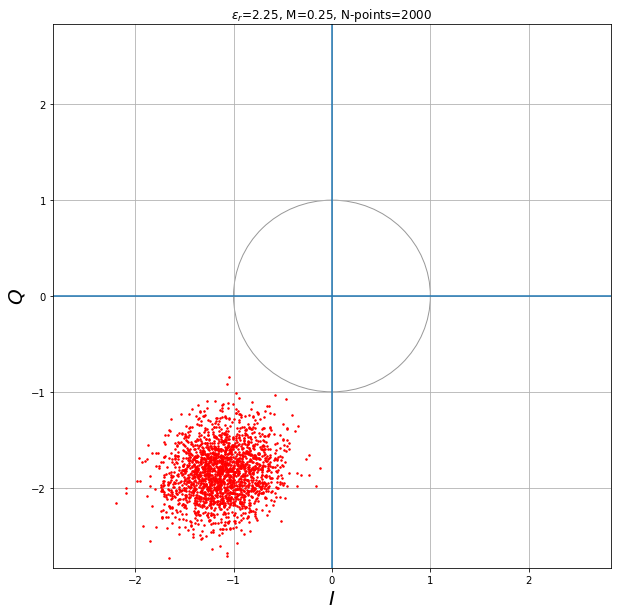

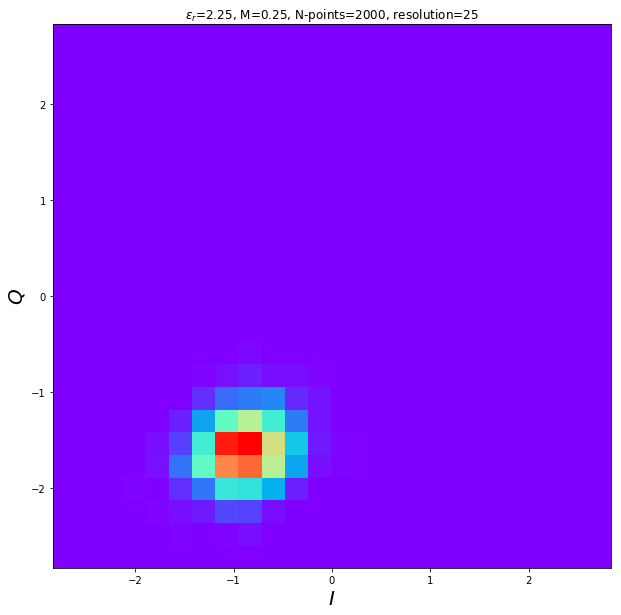

In [2]:
%pylab inline 

import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'spacetime-noise')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)


IQ_samples = np.load(os.path.join(dir_name, 'IQ-samples.npz'))
Q_cos = IQ_samples['Q_cos']
Q_sin = IQ_samples['Q_sin']
n_refr_ind = float(IQ_samples['n_refr_ind'])
M_eps_mod_ind = float(IQ_samples['M_eps_mod_ind'])
N_IQ = int(IQ_samples['N_IQ'])

#n_refr_ind = 1.5
#M_eps_mod_ind = 0.25
#N_IQ = 2000

print('n_refr_ind: ', n_refr_ind)
print('M_eps_mod_ind: ', M_eps_mod_ind)
print('N_IQ: ', N_IQ)

figsize(10, 10)

plt.figure()
plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
#plt.polar(Q_angle, Q_mag)
lim_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin)))+0.1
plt.xlim(-lim_max, lim_max)
plt.ylim(-lim_max, lim_max)
plt.axvline(x=0)
plt.axhline(y=0)
plt.xlabel(r'$I$', fontsize=20)
plt.ylabel(r'$Q$', fontsize=20)
plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}, N-points={2:d}'.format(n_refr_ind**2, M_eps_mod_ind, N_IQ))
plt.grid()

circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
plt.gca().add_artist(circle)

plt.savefig(os.path.join(dir_name, 'IQ-eps={0:.2f}-M={1:.2f}-N-points={2:d}'.format(n_refr_ind**2, M_eps_mod_ind, N_IQ) + file_ext), bbox_inches='tight', pad_inches=0.5)
plt.show()

#np.savez(os.path.join(dir_name, 'IQ-samples'), Q_cos=Q_cos, Q_sin=Q_sin, n_refr_ind=n_refr_ind, M_eps_mod_ind=M_eps_mod_ind, N_IQ=N_IQ)


np.savetxt(os.path.join(dir_name, 'I.csv'), Q_cos, delimiter=",", fmt="%.10e")
np.savetxt(os.path.join(dir_name, 'Q.csv'), Q_sin, delimiter=",", fmt="%.10e")

N = 25
I = np.linspace(-lim_max, lim_max, N)
Q = np.linspace(-lim_max, lim_max, N)
I_grid, Q_grid = np.meshgrid(I, Q, indexing='ij')
Z = np.zeros(I_grid.shape, dtype=float)

for i in range(len(Q_cos)):
    q_cos = Q_cos[i]
    q_sin = Q_sin[i]
    
    ind_i = np.argmax(I>=q_cos)
    ind_j = np.argmax(Q>=q_sin)
    
    Z[ind_i, ind_j] += 1

#plt.imshow(Z.T, interpolation='bilinear', cmap=cm.rainbow, origin='lower', vmax=abs(Z).max(), vmin=0)
plt.pcolor(I_grid, Q_grid, Z, cmap=cm.rainbow)
plt.xlabel(r'$I$', fontsize=20)
plt.ylabel(r'$Q$', fontsize=20)
plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}, N-points={2:d}, resolution={3:d}'.format(n_refr_ind**2, M_eps_mod_ind, N_IQ, N))
plt.savefig(os.path.join(dir_name, 'IQ-hist={0:.2f}-M={1:.2f}-N-points={2:d}-resolution={3:d}'.format(n_refr_ind**2, M_eps_mod_ind, N_IQ, N) + file_ext), bbox_inches='tight', pad_inches=0.5)
plt.show()

